# Datasets N-Dimensionais (astropy.nddata)

De acordo com o site da Astropy¹, a sub-biblioteca astropy.nddata "fornece classes para representar imagens e outros dados em grade", além de possibilitar manipulá-las e muito mais. Veremos a seguir como fazer isso na prática.

### NDData

O objetivo principal do pacote NDData é guardar dados e metadados. Vamos inicialmente criar uma matriz em três dimensões, parecida com a terceira da figura abaixo:

<img src="2-arrays.png" width=50% >

_Imagem disponível em: < https://towardsdatascience.com/numpy-array-cookbook-generating-and-manipulating-arrays-in-python-2195c3988b09 >._

In [1]:
import numpy as np
from astropy.nddata import NDData
array = np.zeros((3, 3, 2))  # Uma matriz tridimensional como a da figura, mas com 0 em cada posição
ndd1 = NDData(array)
print(ndd1)
print(type(ndd1))

[[[0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]]]
<class 'astropy.nddata.nddata.NDData'>


In [2]:
#Podemos criar também dessa forma:

ndd2 = NDData([[1, 2, 3, 4],[5, 6, 7, 8], [9, 10, 11, 12]])
ndd2

NDData([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]])

É possível também a matriz no formato array do numpy, seria algo como o "inverso" do que fizemos anteriormente:

In [3]:
print(ndd2.data)
print(type(ndd2.data))

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]
<class 'numpy.ndarray'>


Mas pense só, se fosse apenas isso, não faria sentido trabalhar com NDData. Então qual a vantagem de trabalhar com NDData e não com as matrizes numpy convencionais?\
A vantagem é que ele suporta propriedades adicionais, como $unit$ (unidade), $mask$, $wcs$ (World Coordinate System), $uncertainty$ (incertezas ou desvio padrão) e $meta$ (atributos adicionais). Vejamos:

In [4]:
from astropy.nddata import StdDevUncertainty

data = np.array([1,2,3,4])
mask = data > 2 #gera uma lista assim: [False False True True], indicando quais pontos são válidos ou não.

unit = 'erg / s'
uncertainty = StdDevUncertainty(np.sqrt(data)) # Calculando o desvio padrão
meta = {'object': 'fictional data.'}

ndd = NDData(data, mask=mask, unit=unit, uncertainty=uncertainty, meta=meta)
ndd

NDData([1, 2, 3, 4])

In [5]:
#Para acessar mask:
ndd.mask

array([False, False,  True,  True])

In [6]:
#Para saber mais e entender melhor os parâmetros:
NDData?

## NDDataRef

Se você tentar somar os objetos NDData, irá obter uma mensagem de erro.

In [7]:
ndd + ndd

TypeError: unsupported operand type(s) for +: 'NDData' and 'NDData'

Para fazer essa e outras operações, utilizaremos NDDataRef:

In [8]:
from astropy.nddata import NDDataRef
ndd1 = NDDataRef(ndd)
print(ndd1)
print(type(ndd1))

[1 2 3 4]
<class 'astropy.nddata.nddata_withmixins.NDDataRef'>


In [9]:
import astropy.units as u
ndd2 = ndd1.add([4, -3.5, 3, 2.5] * u.erg / u.s)
ndd2

NDDataRef([ 5. , -1.5,  6. ,  6.5])

In [10]:
print(ndd2[2:])  # escolhendo elementos a partir do terceiro
print(ndd2[1])   # estamos escolhendo o segundo elemento

[6.  6.5]
-1.5


In [11]:
#Para mostrar que sem o NDDataRef isso não é possível:
ndd[1]

TypeError: 'NDData' object is not subscriptable

Trabalhando com dados bidimensionais como imagens

O pacote nddata suporta qualquer tipo de dados em grade, mas vamos nos concentrar no uso de nddata para imagens bidimensionais.

Primeiro vamos construir uma imagem bidimensional com algumas fontes, algum ruído gaussiano e um "raio cósmico":

In [12]:
import numpy as np
from astropy.modeling.models import Gaussian2D
Gaussian2D?

Para isso, usaremos a np.mgrid. Através do valor informado, teremos uma matriz com um formato e valores peculiares: 

In [13]:
teste = np.mgrid[0:4, 0:4]
print(teste)
print(type(teste))

[[[0 0 0 0]
  [1 1 1 1]
  [2 2 2 2]
  [3 3 3 3]]

 [[0 1 2 3]
  [0 1 2 3]
  [0 1 2 3]
  [0 1 2 3]]]
<class 'numpy.ndarray'>


In [14]:
#Aqui estamos fazendo a mesma coisa que na célula acima, mas separando em duas partes (y e x)
y, x = np.mgrid[0:500, 0:600]
print('y:', y)
print('x:', x)

y: [[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [497 497 497 ... 497 497 497]
 [498 498 498 ... 498 498 498]
 [499 499 499 ... 499 499 499]]
x: [[  0   1   2 ... 597 598 599]
 [  0   1   2 ... 597 598 599]
 [  0   1   2 ... 597 598 599]
 ...
 [  0   1   2 ... 597 598 599]
 [  0   1   2 ... 597 598 599]
 [  0   1   2 ... 597 598 599]]


Agora utilizaremos uma Gaussiana. Mas calme, não se assuste! Aqui você poderá ver rapidamente o que isso significa: http://astro.if.ufrgs.br/med/imagens/node58.htm.
Como explicado no link acima, uma gaussiana é dada por:

\begin{equation}
f(x) = e^{-x^2/2 \sigma}
\end{equation}

Vamos então verificar o que Gaussian2D nos pede:

In [15]:
Gaussian2D

<class 'astropy.modeling.functional_models.Gaussian2D'>
Name: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Fittable parameters: ('amplitude', 'x_mean', 'y_mean', 'x_stddev', 'y_stddev', 'theta')

Ou seja, nos pede a amplitude, o valor de x médio, o valor de y médio, o desvio padrao da gaussiana em x e em y e o valor de theta (que na equação é representado por sigma.

In [16]:
#As somas foram feitas dessas formas para facilitar a visualização

data = (Gaussian2D(1, 150, 100, 20, 10, theta=0.5)(x, y) +
        Gaussian2D(0.5, 400, 300, 8, 12, theta=1.2)(x,y) +
        Gaussian2D(0.75, 250, 400, 5, 7, theta=0.23)(x,y) +
        Gaussian2D(0.9, 525, 150, 3, 3)(x,y) +
        Gaussian2D(0.6, 200, 225, 3, 3)(x,y))

print(type(data))
print(data.shape) #para você ver que as dimensões não mudaram
print(data)

<class 'numpy.ndarray'>
(500, 600)
[[8.87017882e-019 1.21655886e-018 1.66149666e-018 ... 3.20394009e-263
  3.52977670e-264 3.87235956e-265]
 [1.25892443e-018 1.73209152e-018 2.37305392e-018 ... 2.99153692e-262
  3.30618869e-263 3.63853454e-264]
 [1.77203653e-018 2.44576241e-018 3.36140979e-018 ... 2.77019325e-261
  3.07124003e-262 3.39065068e-263]
 ...
 [1.21077709e-303 1.71734958e-302 2.41625233e-301 ... 4.82581138e-224
  2.55113566e-224 1.34295779e-224]
 [2.23825487e-304 3.16541628e-303 4.44059524e-302 ... 7.36925480e-225
  3.90802386e-225 2.06374692e-225]
 [4.07815785e-305 5.75058603e-304 8.04357736e-303 ... 1.11604710e-225
  5.93726701e-226 3.14525771e-226]]


In [17]:
data += 0.01 * np.random.randn(500, 600) #Adicionando um ruído nos dados
#Lembre-se que o sinal += significa que estamos somando a variável antes de += com o que tem após +=

valor_do_raio_cosmico = 0.997 #Definindo um valor para o nosso "raio cósmico"
data[100, 300:310] = valor_do_raio_cosmico #Definindo até onde irá esse nosso "raio cósmico"

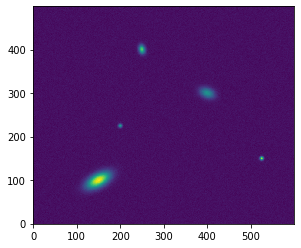

In [20]:
import matplotlib.pyplot as plt
plt.imshow(data, origin='lower')
plt.show()

Vamos parar por aqui hoje. Recomenda-se mudar os valores fornecidos para se obter diferentes imagens e assim entender melhor o código desenvolvido aqui.
Nesta pasta/repositório há um arquivo em python que pode ser executado no seu terminal para obter a imagem.

Fontes do texto:\
1 - ASTROPY. "N-Dimensional Datasets (astropy.nddata)". Disponível em: < https://docs.astropy.org/en/stable/nddata/index.html >. Acesso em: 24 de novembro de 2020.

Fontes do código:\
ASTROPY. "N-Dimensional Datasets (astropy.nddata)". Disponível em: < https://docs.astropy.org/en/stable/nddata/index.html >. Acesso em: 24 de novembro de 2020.